# Исследование объявлений о продаже квартир



Цель исследования — сформировать параметры определения рыночной стоимости объектов недвижимости для создания автоматизированной системы:  


Ход исследования

Данные о поданных объектах недвижимости предоставлены в необработанном виде. Перед анализом необходимо провести предобработку данных, убрать пропущенные значения и дубликаты, где это возможно.


Таким образом, исследование пройдёт в четыре этапа:

* Обзор данных;  
* Предобработка данных;  
* Анализ данных;  
* Вывод по произведённому анализу.

### Обзор данных

Импортируем необходимые бибилиотеки, также выгружаем основную для анализа информацию о датафрейме.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

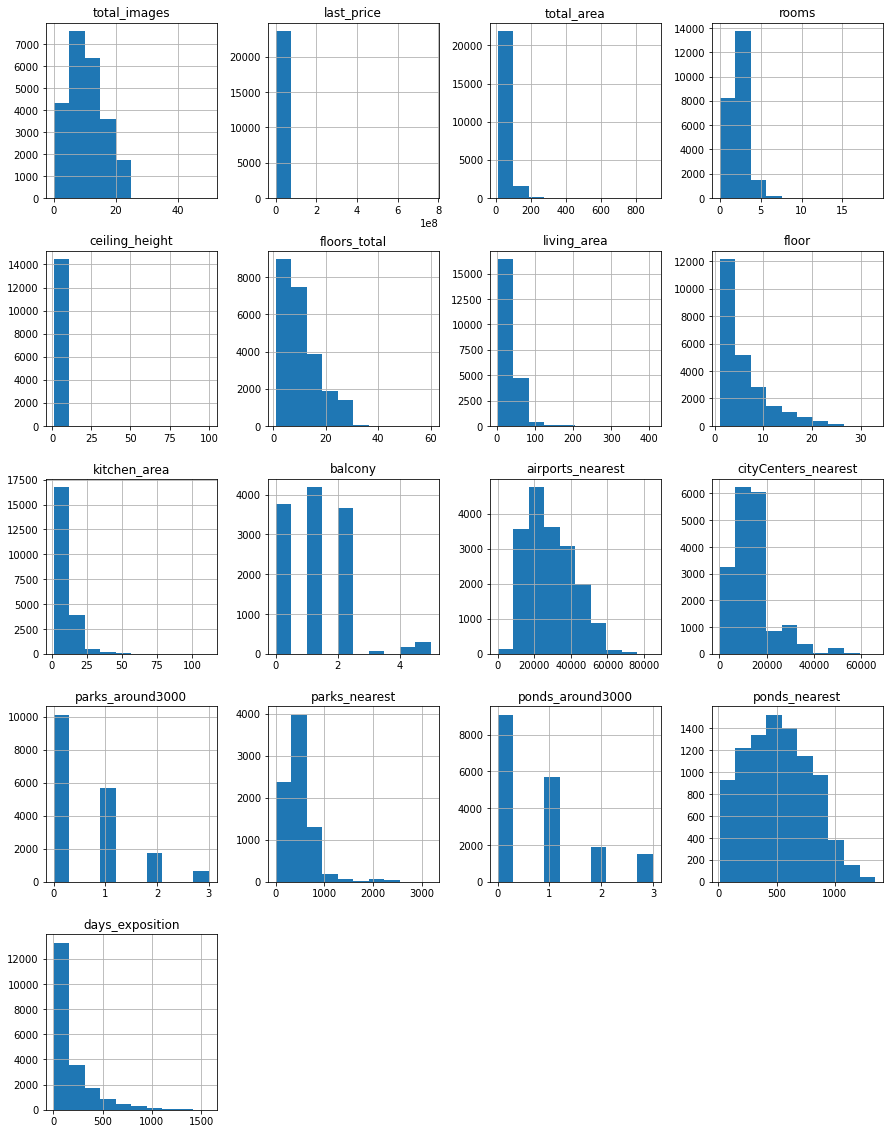

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn


df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
print (df.info())
print (df.head())
df.hist(figsize=(15, 20));

### Предобработка данных

Проверяем, сколько пустых значений в таблице.

In [3]:
print (df.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64


Можно заполнить пустые значения имеющимися данными в следующих столбцах:  
    balcony - скорее всего не заполнялся при отсутствии признака;  
    living_area - заменим медианным показателем;  
    locality_name - удалим строки с пустыми значениями;  
    floors_total - положим в него значение столбца floor;  
    kitchen_area - заменим медианным показателем;  
    is_apartment - скорее всего не заполнялся при отсутствии признака;  
    ceiling_height - скорректируем аномалии (чуть позже).  
    
В последних 7 столбцах нет возможности заменить пустые значения, основываясь на имеющихся данных, поскольку они получены на основе картографических данных.

Пустые значения в столбце balcony можно заменить нулями. Вероятно при отсутствии балкона пользователь пропускал этот пункт.

In [4]:
df['balcony'] = df['balcony'].fillna(0)

Проверяем вазимосвязь дней публикации с другими параматерами, чтобы заполнить пустые данные.

In [5]:
df.corr()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
total_images,1.000000,0.104473,0.115352,0.099288,-0.001987,0.010427,0.104780,0.031340,-0.029303,-0.024407,0.104756,0.048903,-0.002298,-0.047666,0.021120,-0.008347,-0.011553,-0.003034,-0.026657
last_price,0.104473,1.000000,0.653675,0.363343,0.085430,-0.006984,0.566492,0.026576,-0.025362,-0.008802,0.519869,0.008559,-0.026239,-0.206747,0.151058,-0.016414,0.159996,-0.084809,0.081146
total_area,0.115352,0.653675,1.000000,0.758344,0.095490,-0.075774,0.939537,-0.024754,-0.072653,-0.034885,0.609121,0.009941,-0.030753,-0.231446,0.164689,-0.021497,0.162346,-0.097969,0.149675
rooms,0.099288,0.363343,0.758344,1.000000,0.054457,-0.228215,0.845977,-0.150862,-0.147286,-0.087500,0.269945,-0.015519,-0.061199,-0.184864,0.137257,-0.054549,0.092693,-0.057689,0.126961
ceiling_height,-0.001987,0.085430,0.095490,0.054457,1.000000,-0.028732,0.090650,-0.011798,0.001674,0.042777,0.087641,0.031216,-0.023947,-0.091689,0.065915,-0.019167,0.078209,-0.059090,0.019091
floors_total,0.010427,-0.006984,-0.075774,-0.228215,-0.028732,1.000000,-0.169311,0.678059,0.070151,0.050791,0.163944,0.172812,0.108288,0.019774,-0.252833,0.097527,-0.122735,0.038864,-0.052234
living_area,0.104780,0.566492,0.939537,0.845977,0.090650,-0.169311,1.000000,-0.097210,-0.056231,-0.033711,0.428674,-0.014772,-0.057912,-0.231368,0.184453,-0.050167,0.148933,-0.081674,0.142454
floor,0.031340,0.026576,-0.024754,-0.150862,-0.011798,0.678059,-0.097210,1.000000,0.036940,0.035824,0.135531,0.168567,0.071597,0.009084,-0.163784,0.073045,-0.076312,0.024850,-0.039463
studio,-0.029303,-0.025362,-0.072653,-0.147286,0.001674,0.070151,-0.056231,0.036940,1.000000,-0.004235,NaN,0.028899,-0.021876,-0.007029,-0.030202,0.009134,0.000939,0.002606,-0.022476
open_plan,-0.024407,-0.008802,-0.034885,-0.087500,0.042777,0.050791,-0.033711,0.035824,-0.004235,1.000000,NaN,0.032639,-0.013583,-0.004204,-0.010077,0.010612,0.008455,-0.003328,-0.024112


Наиболее высокая корреляция у жилой площади выявлена с количеством комнат, поэтому заменим пустые значения медианным показателем.

In [6]:
df_liv_area_med = df.groupby('rooms')['living_area'].median()
for row in df_liv_area_med.index:
    df.loc[(df['rooms'] == row)& (df['living_area'].isna()), 'living_area'] = df_liv_area_med[row]
print (df_liv_area_med)

rooms
0      18.000
1      17.600
2      30.500
3      45.000
4      63.600
5      91.785
6     123.900
7     145.000
8     161.000
9     179.200
10    161.400
11    133.900
12    409.700
14    195.150
15    409.000
16    180.000
19    264.500
Name: living_area, dtype: float64


Удаляем строки без населённых пунктов, их всего 0,02%, заменить их ничем нельзя

In [7]:
df = df.dropna(subset=['locality_name'])

Заполняем пустые значения в кол-ве этажей в здании этажом квартиры.

In [8]:
df['floors_total'] = df['floors_total'].fillna(df['floor'])

Возвращаясь к таблице корреляции, взаимосвязь общей площади с площадью кухни наиболее высока.  
По этой причине пустые значения заполним медианным значением столбца total_area.  

In [9]:
df_total_area_med = df.groupby('total_area')['kitchen_area'].median()
for row in df_total_area_med.index:
    df.loc[(df['total_area'] == row)& (df['kitchen_area'].isna()), 'kitchen_area'] = df_total_area_med[row]
print (df_total_area_med)

total_area
12.0       NaN
13.0       NaN
13.2       NaN
14.0       2.0
15.0       NaN
         ...  
590.0    100.0
618.0     70.0
631.0     60.0
631.2     19.5
900.0    112.0
Name: kitchen_area, Length: 2181, dtype: float64


Заполняем пустые значения в Is_apartament нулями. Как и с балконами, не проставлен отрицательный признак.

In [10]:
df['is_apartment'] = df['is_apartment'].fillna(0)

Расстояние до центра можно заполнить медианным значением по населённому пункту:

In [11]:
df_nearest_centre_med = df.groupby('locality_name')['cityCenters_nearest'].median()
for row in df_nearest_centre_med.index:
    df.loc[(df['locality_name'] == row)& (df['cityCenters_nearest'].isna()), 'cityCenters_nearest'] = df_nearest_centre_med[row]
print (df_nearest_centre_med)

locality_name
Бокситогорск           NaN
Волосово               NaN
Волхов                 NaN
Всеволожск             NaN
Выборг                 NaN
                        ..
село Путилово          NaN
село Рождествено       NaN
село Русско-Высоцкое   NaN
село Старая Ладога     NaN
село Шум               NaN
Name: cityCenters_nearest, Length: 364, dtype: float64


Проверяем, скорректированы ли пропущенные значения:

In [12]:
print (df.isna().sum())
pd.DataFrame(round(df.isna().mean()*100,)).style.background_gradient('coolwarm')

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9160
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area              205
balcony                     0
locality_name               0
airports_nearest         5534
cityCenters_nearest      5386
parks_around3000         5510
parks_nearest           15586
ponds_around3000         5510
ponds_nearest           14565
days_exposition          3180
dtype: int64


,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,39.000000
floors_total,0.000000
living_area,0.000000
floor,0.000000
is_apartment,0.000000


Выведем информацию о типе данных:

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23650 non-null  int64  
 1   last_price            23650 non-null  float64
 2   total_area            23650 non-null  float64
 3   first_day_exposition  23650 non-null  object 
 4   rooms                 23650 non-null  int64  
 5   ceiling_height        14490 non-null  float64
 6   floors_total          23650 non-null  float64
 7   living_area           23650 non-null  float64
 8   floor                 23650 non-null  int64  
 9   is_apartment          23650 non-null  object 
 10  studio                23650 non-null  bool   
 11  open_plan             23650 non-null  bool   
 12  kitchen_area          23445 non-null  float64
 13  balcony               23650 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Для замены типов данных было принято решение выбрать следующие столбцы:  
* last_price  
* first_day_exposition  
* floors_total  
* balcony  

Значения в данных столбцах целые, поэтому нет потребности держать тип данных float.


In [14]:
df['last_price'] = df['last_price'].astype(int)
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
df['floors_total'] = df['floors_total'].astype(int)
df['balcony'] = df['balcony'].astype(int)

Проверим результат изменения типа данных

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23650 non-null  int64         
 1   last_price            23650 non-null  int64         
 2   total_area            23650 non-null  float64       
 3   first_day_exposition  23650 non-null  datetime64[ns]
 4   rooms                 23650 non-null  int64         
 5   ceiling_height        14490 non-null  float64       
 6   floors_total          23650 non-null  int64         
 7   living_area           23650 non-null  float64       
 8   floor                 23650 non-null  int64         
 9   is_apartment          23650 non-null  object        
 10  studio                23650 non-null  bool          
 11  open_plan             23650 non-null  bool          
 12  kitchen_area          23445 non-null  float64       
 13  balcony         

**Ликвидация неявных дубликатов** 

В населённых пунктах замечены неявные дубликаты.  
Для их устранения выведем список уникальных значений.

In [16]:
print (df['locality_name'].unique())

['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'поселок Новый Све

In [17]:
df['locality_name']=df['locality_name'].str.replace('ё','е')

In [18]:
df['locality_name']= df['locality_name'].str.replace('городской поселок ','')
df['locality_name']= df['locality_name'].str.replace('поселок городского типа ','')
df['locality_name']= df['locality_name'].str.replace('коттеджный поселок ','')
df['locality_name']= df['locality_name'].str.replace('деревня ','')
df['locality_name']= df['locality_name'].str.replace('поселок ','')
df['locality_name']= df['locality_name'].str.replace('село ','')
df['locality_name']= df['locality_name'].str.replace('садовое товарищество ','')
df['locality_name']= df['locality_name'].str.replace('при железнодорожной станции ','')
df['locality_name']= df['locality_name'].str.replace('станции ','')
df['locality_name']= df['locality_name'].str.replace('садоводческое некоммерческое товарищество','СНТ')

Проверим результат корректировок:

In [19]:
print (df['locality_name'].unique())

['Санкт-Петербург' 'Шушары' 'Янино-1' 'Парголово' 'Мурино' 'Ломоносов'
 'Сертолово' 'Петергоф' 'Пушкин' 'Кудрово' 'Коммунар' 'Колпино'
 'Красный Бор' 'Гатчина' 'Федоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'Новое Девяткино' 'Металлострой' 'Лебяжье' 'Сиверский' 'Молодцово'
 'Кузьмоловский' 'Новая Ропша' 'Павловск' 'Пикколово' 'Всеволожск'
 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк' 'Куттузи' 'Аннино'
 'Ефимовский' 'Плодовое' 'Заклинье' 'Торковичи' 'Первомайское'
 'Красное Село' 'Понтонный' 'Сясьстрой' 'Старая' 'Лесколово' 'Новый Свет'
 'Сланцы' 'Путилово' 'Ивангород' 'Шлиссельбург' 'Никольское' 'Зеленогорск'
 'Сосновый Бор' 'Оржицы' 'Кальтино' 'Романовка' 'Бугры' 'Рощино' 'Кириши'
 'Луга' 'Волосово' 'Отрадное' 'Павлово' 'Оредеж' 'Копорье' 'Молодежное'
 'Тихвин' 'Победа' 'Нурма' 'Синявино' 'Тосно' 'Стрельна' 'Бокситогорск'
 'Александровская' 'Лопухинка' 'Пикалево' 'Терволово' 'Советский'
 'Подпорожье' 'Петровское' 'Токсово' 'Сельцо' 'Вырица' 'Кипень' 'Келози'
 'Вартемяги' 'Тельмана' '

Для корректировки значений в столбце ceiling_heght проверим выбросы:

(0.0, 30.0)

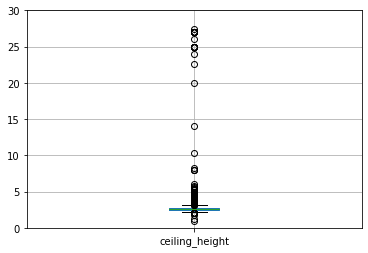

In [20]:
df.boxplot(column='ceiling_height')
plt.ylim(0, 30)

Заменим аномалии:

In [21]:
df= df.replace({'ceiling_height': {20:2, 
                                   22.6:2.26, 
                                   24:2.4, 
                                   25:2.5, 
                                   26:2.6, 
                                   27:2.7, 
                                   27.5:2.75, 
                                   32:3.2, 
                                   100:10
                                  }})

Для выявления выбросов построим диаграммы размаха по основным показателям:

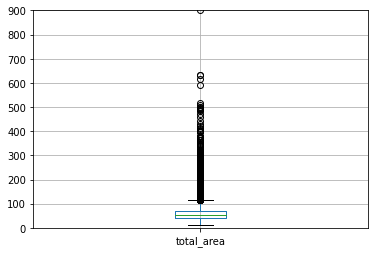

count    23650.000000
mean        60.329069
std         35.661808
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64


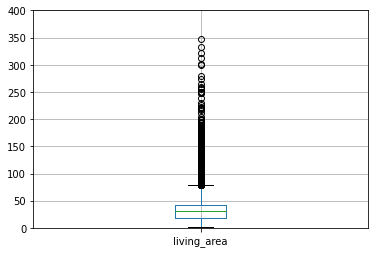

count    23650.000000
mean        34.313121
std         21.708464
min          2.000000
25%         18.400000
50%         30.300000
75%         42.700000
max        409.700000
Name: living_area, dtype: float64


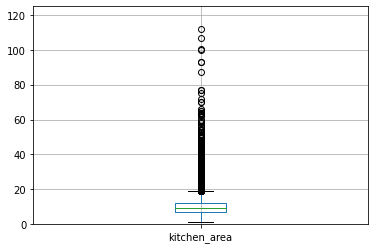

count    23445.000000
mean        10.454360
std          5.779649
min          1.300000
25%          7.000000
50%          9.000000
75%         11.800000
max        112.000000
Name: kitchen_area, dtype: float64


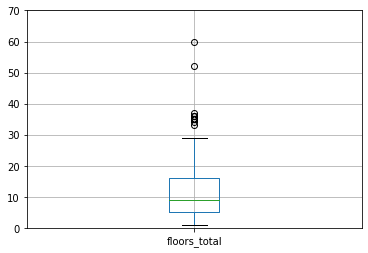

count    23650.000000
mean        10.673784
std          6.593455
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64


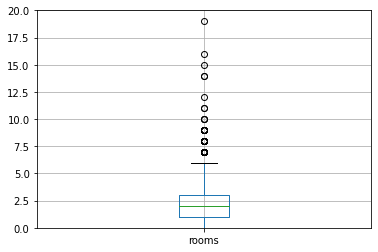

count    23650.000000
mean         2.070106
std          1.078620
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64


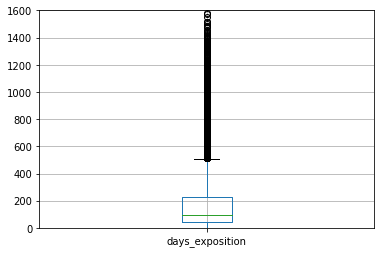

count    20470.000000
mean       180.753200
std        219.777916
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64


In [22]:
df.boxplot(column='total_area')
plt.ylim(0, 900)
plt.show() 
print (df['total_area'].describe())

df.boxplot(column='living_area')
plt.ylim(0, 400)
plt.show() 
print (df['living_area'].describe())

df.boxplot(column='kitchen_area')
plt.ylim(0, 125)
plt.show()   
print (df['kitchen_area'].describe())

df.boxplot(column='floors_total')
plt.ylim(0, 70)
plt.show()   
print (df['floors_total'].describe())

df.boxplot(column='rooms')
plt.ylim(0, 20)
plt.show()   
print (df['rooms'].describe())

df.boxplot(column='days_exposition')
plt.ylim(0, 1600)
plt.show()   
print (df['days_exposition'].describe())

Было принято решение избавиться не от всех выбросов ("усов"), а лишь от максимально выбивающихся значений, иначе потеряется больше трети данных. Ниже приведены ограничения, введённые на данные, также продемонстрированы изменённые данные.

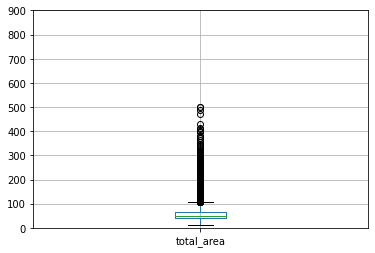

count    20127.000000
mean        58.446511
std         31.196217
min         14.000000
25%         40.000000
50%         50.900000
75%         67.600000
max        500.000000
Name: total_area, dtype: float64


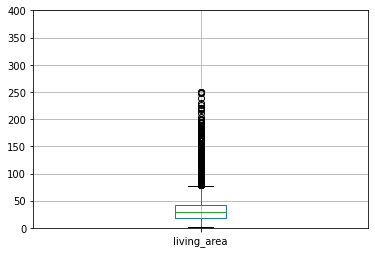

count    20127.000000
mean        33.222045
std         19.570423
min          2.000000
25%         18.100000
50%         30.000000
75%         41.990000
max        250.000000
Name: living_area, dtype: float64


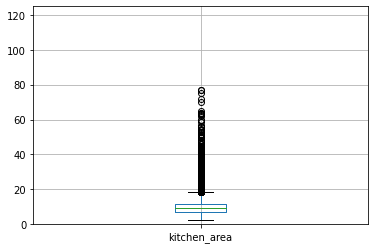

count    20127.000000
mean        10.249921
std          5.235982
min          2.000000
25%          7.000000
50%          9.000000
75%         11.500000
max         77.000000
Name: kitchen_area, dtype: float64


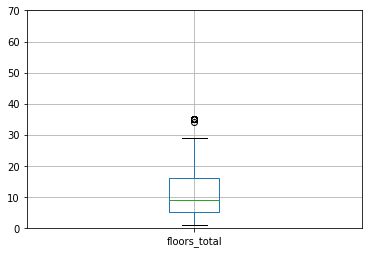

count    20127.000000
mean        10.801461
std          6.578056
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         35.000000
Name: floors_total, dtype: float64


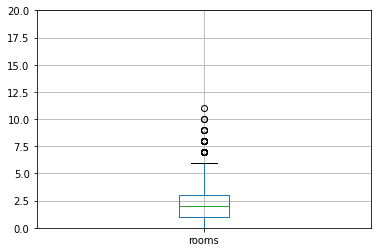

count    20127.000000
mean         2.023054
std          1.018055
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         11.000000
Name: rooms, dtype: float64


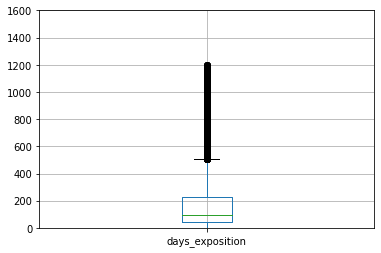

count    20127.000000
mean       176.055845
std        206.473654
min          1.000000
25%         45.000000
50%         95.000000
75%        229.000000
max       1200.000000
Name: days_exposition, dtype: float64


In [23]:
df = df.query('total_area <= 500'
              'and rooms <= 12'
              'and living_area <= 250'
              'and kitchen_area <= 80'
              'and floors_total <= 35'
              'and days_exposition <= 1200'
             )
df = df[df['floor'] <= 25]  


df.boxplot(column='total_area')
plt.ylim(0, 900)
plt.show() 
print (df['total_area'].describe())

df.boxplot(column='living_area')
plt.ylim(0, 400)
plt.show() 
print (df['living_area'].describe())

df.boxplot(column='kitchen_area')
plt.ylim(0, 125)
plt.show()   
print (df['kitchen_area'].describe())

df.boxplot(column='floors_total')
plt.ylim(0, 70)
plt.show()   
print (df['floors_total'].describe())

df.boxplot(column='rooms')
plt.ylim(0, 20)
plt.show()   
print (df['rooms'].describe())

df.boxplot(column='days_exposition')
plt.ylim(0, 1600)
plt.show()   
print (df['days_exposition'].describe())

В результате применённых ограничений были отсечены 15% всех данных (от изначального кол-ва строк).

Проверим данные на дубликаты:

In [24]:
print (df.duplicated().sum())

0


Дубликатов нет, можно переходить к следующему этапу.

**Вывод**  
Поскольку статистические данные изначально не пригодны для дальнейшего анализа, в этом разделе была проведена предобработка данных:
* Выявлены пустые значения в столбцах;  
* В столбцах balcony и is_apartment пустые значения заменены на 0;  
* Столбцы living_area, kitchen_area заполнены медианными показателями, учитывая вес корреляции с другими столбцами;  
* Строки с незаполненными населёнными пунктами удалены, поскольку составляют меньше 0,5% и заменить их нельзя;  
* Преобразованы типы данных;
* Ликвидированы неявные дубликаты в названиях населённых пунктов;
* Датафрейм преобразован, отброшены выбросы в основных показателях, которые искажают статистические данные, в т.ч. средние показатели.


### Посчитайте и добавьте в таблицу новые столбцы

Добавим столбец стоимости за один метр путём деления цены на момент снятия публикации на общую площадь

In [25]:
df['cost_one_meter'] = df['last_price']/df['total_area']

Добавим столбцы о дне, месяце и годе публикации объявления

In [26]:
df['weekday_publication'] = df['first_day_exposition'].dt.weekday
df['month_publication'] = df['first_day_exposition'].astype('datetime64[M]')
df['year_publication'] = df['first_day_exposition'].dt.year
print (df.head())

   total_images  last_price  total_area first_day_exposition  rooms  \
1             7     3350000        40.4           2018-12-04      1   
2            10     5196000        56.0           2015-08-20      2   
3             0    64900000       159.0           2015-07-24      3   
4             2    10000000       100.0           2018-06-19      2   
5            10     2890000        30.4           2018-09-10      1   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
1             NaN            11         18.6      1            0  ...   
2             NaN             5         34.3      4            0  ...   
3             NaN            14         45.0      9            0  ...   
4            3.03            14         32.0     13            0  ...   
5             NaN            12         14.4      5            0  ...   

   cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
1              18603.0               0.0            NaN  

Добавим столбец floor_location, в котором определена категория этажа квартиры: находится она на первом этаже, последнем или прочем.

In [27]:
def floor_number (floor):
    if floor['floor'] == 1:
        return 'первый'
    elif floor['floor'] == floor['floors_total']:
        return 'последний'
    else: 
        return 'другой'

df['floor_location'] = df[['floor', 'floors_total']].apply(floor_number, axis=1)
print (df.head(20))

    total_images  last_price  total_area first_day_exposition  rooms  \
1              7     3350000        40.4           2018-12-04      1   
2             10     5196000        56.0           2015-08-20      2   
3              0    64900000       159.0           2015-07-24      3   
4              2    10000000       100.0           2018-06-19      2   
5             10     2890000        30.4           2018-09-10      1   
6              6     3700000        37.3           2017-11-02      1   
9             18     5400000        61.0           2017-02-26      3   
10             5     5050000        39.6           2017-11-16      1   
11             9     3300000        44.0           2018-08-27      2   
12            10     3890000        54.0           2016-06-30      2   
13            20     3550000        42.8           2017-07-01      2   
14             1     4400000        36.0           2016-06-23      1   
15            16     4650000        39.0           2017-11-18   

Добавим столбец с расстоянием до центра города в км и проверяем результат:

In [28]:
df['km_to_centre'] = (df['cityCenters_nearest']/1000).round()

Проверим, добавились ли новые столбцы

In [29]:
print (df.head())

   total_images  last_price  total_area first_day_exposition  rooms  \
1             7     3350000        40.4           2018-12-04      1   
2            10     5196000        56.0           2015-08-20      2   
3             0    64900000       159.0           2015-07-24      3   
4             2    10000000       100.0           2018-06-19      2   
5            10     2890000        30.4           2018-09-10      1   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
1             NaN            11         18.6      1            0  ...   
2             NaN             5         34.3      4            0  ...   
3             NaN            14         45.0      9            0  ...   
4            3.03            14         32.0     13            0  ...   
5             NaN            12         14.4      5            0  ...   

   parks_nearest  ponds_around3000  ponds_nearest  days_exposition  \
1            NaN               0.0            NaN             81

**Вывод**  
Для более подробных подсчётов были добавлены следующие показатели:  
* цена за один метр;
* выделены в отдельные столбцы день, месяц и год публикации объявления, впоследствии они понадобятся для анализа взаимосвязи с ценой объекта;
* расстояние от квартиры до центра города в км для более наглядного представления данных.

### Проведите исследовательский анализ данных

<AxesSubplot:>

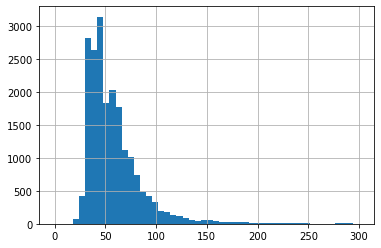

In [30]:
df['total_area'].hist(bins=50, range=(0,300))

На гистограмме видно, что у большинства исследуемых квартир общая площадь около 50 м2. В целом практически у всех квартир значения варьируются от 30 до 100 м2.

<AxesSubplot:>

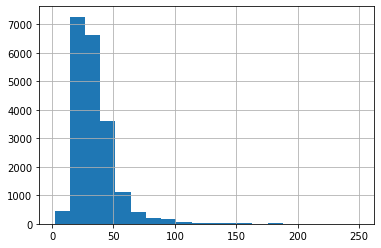

In [31]:
df['living_area'].hist(bins=20)

Жилая площадь у большинства квартир около 25 м2, диапазон основных значений составляет 25-75 м2.

<AxesSubplot:>

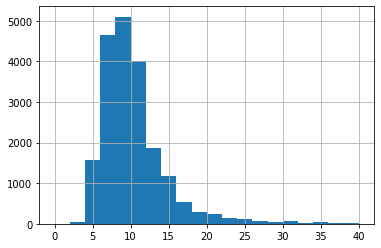

In [32]:
df['kitchen_area'].hist(bins=20,range=(0,40))

Согласно исследуемым данным пик значений площади кухни примерно 10 м2, в большинстве своём значения варьируются от 6 до 12 м2.

<AxesSubplot:>

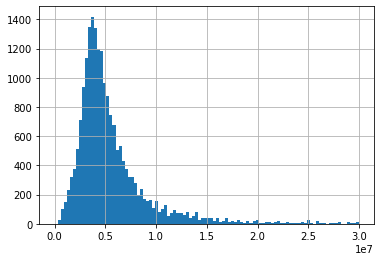

In [33]:
df['last_price'].hist(bins=100, range=(0,30000000))

Большинство квартир продались по цене в диапазоне от 3 млн руб до 6 млн руб.

<AxesSubplot:>

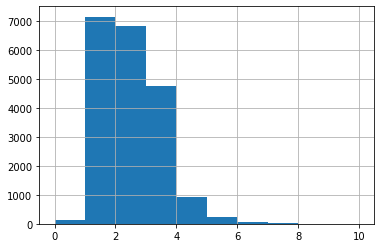

In [34]:
df['rooms'].hist(bins=10, range=(0,10))

Наиболее часто встречаемые показатели кол-ва комнат в продаваемых квартирах - от одной до четырёх комнат.

<AxesSubplot:>

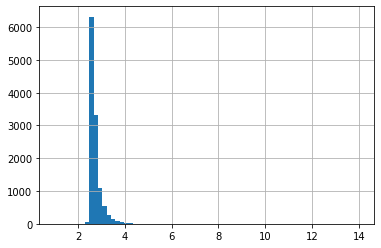

In [35]:
df['ceiling_height'].hist(bins=70)

Самая распространённая высота потолков в выборке составляет 2,7м, больше 3м показатели встречаются редко. 

<AxesSubplot:>

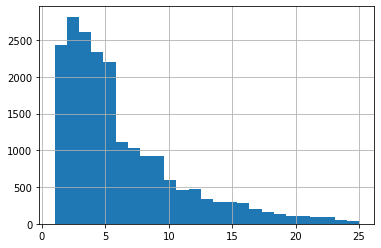

In [36]:
df['floor'].hist(bins=25)

Чаще продавались квартиры на низких этажах, наиболее частые показатели встречаются в диапазоне 2-4 этажей.

<AxesSubplot:>

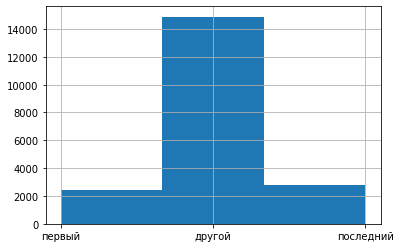

In [37]:
df['floor_location'].hist(bins=3)

Глядя на гистограмму видно, чаще других покупали квартиры не на первом, и не на последнем этажах. Это вполне логично, учитывая, что в категорию "другой " попадают почти все значения, кроме первого и последнего этажей.

<AxesSubplot:>

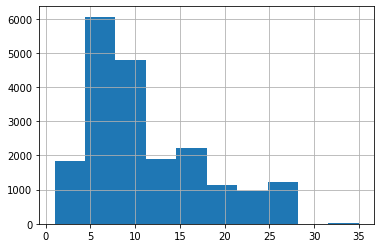

In [38]:
df['floors_total'].hist(bins=10)

Большинство домов, в которых покупали квартиры не очень высокие, их общее количество этажей составляет от 5 до 10 этажей.

<AxesSubplot:>

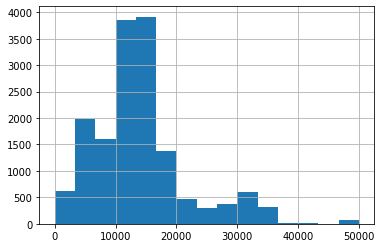

In [39]:
df['cityCenters_nearest'].hist(bins=15, range=(0,50000))

Покупатели отдавали предпочтение квартирам, которые находятся недалеко от центра города, приблизительно в 1-2 км.

<AxesSubplot:>

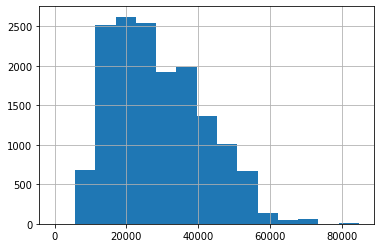

In [40]:
df['airports_nearest'].hist(bins=15)

По гистограмме видно, что чаще всего расстояние до ближайшего аэропорта составляет 15-25 км. Такой результат кажется логичным, поскольку аэропорты находятся за чертой города, а в прежней гистограмме видно, что предпочтительнее всего квартиры недалеко от центра города.

<AxesSubplot:>

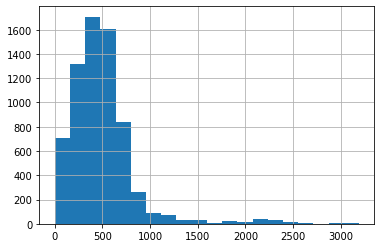

In [41]:
df['parks_nearest'].hist(bins=20)

У большинства проданных квартир ближайший парк находится достаточно близко - примерно на расстоянии 400-600 м.

<AxesSubplot:>

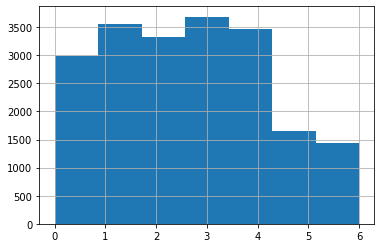

In [42]:
df['weekday_publication'].hist(bins=7)

Большинство объявлений было выложено в четверг. Заметно, что в выходные идёт спад на выставление объявлений - скорее всего в это время либо проходят показы уже выставленных квартир, либо подготовка квартиры к публикации. 

<AxesSubplot:>

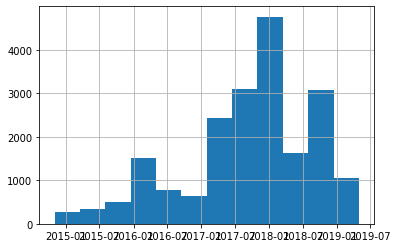

In [43]:
df['month_publication'].hist(bins=12)

Большинство объявлений выложено было в феврале, это можно связать с тем, что в зимний период декабрь, январь объявлений намного меньше (подготовка к праздникам и непосредственно новогодние каникулы). По этой причине после такого затишья наблюдается всплеск объявлений. Наименьшее же количество объявлений выложены в мае.

<AxesSubplot:>

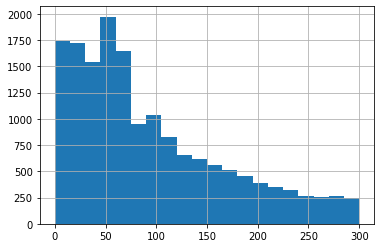

In [44]:
df['days_exposition'].hist(bins=20, range=(0,300))

<AxesSubplot:>

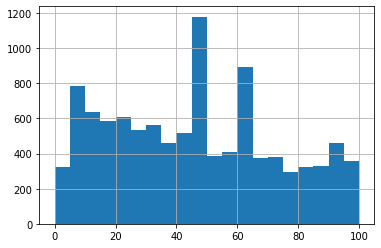

In [45]:
df['days_exposition'].hist(bins=20, range=(0,100))

In [46]:
print('Среднее количество дней размещения объявления:', df['days_exposition'].mean())
print('Медианное количество дней размещения объявления:', df['days_exposition'].median())

Среднее количество дней размещения объявления: 176.0558453818254
Медианное количество дней размещения объявления: 95.0


Несмотря на среднее количество дней размещения объявления в 176 дней медианное значение составляет 95 дней, это связано как раз с выбивающимися значениями.  

Продажа в большинстве случаев занимает от 50 до 70 дней. Однако объявление может висеть и дольше 600 дней (больше года). Очевидно, такие объявления требуют корректировок либо в цене, либо в самой квартире. Также заметны и очень быстрые продажи - от 0 до 25 дней. Это может быть свзано с очень низкой ценой за объект.

**Проанализируем данные стоимости квартиры в группировке с разными показателями.**

<AxesSubplot:xlabel='last_price', ylabel='total_area'>

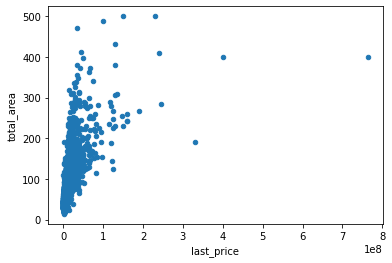

In [47]:
df.plot(x='last_price', y='total_area', kind='scatter')

Проверим взаимосвязь с помощью корреляции Пирсона:

In [48]:
print(df['last_price'].corr(df['total_area']))

0.6117063841304599


Наглядно видно, что показатель корреляции достаточно высокий. Вполне логично, что чем выше общая площади квартиры, тем выше цена, ведь выставляется цена из расчёта за каждый квадратный метр.

<AxesSubplot:xlabel='last_price', ylabel='living_area'>

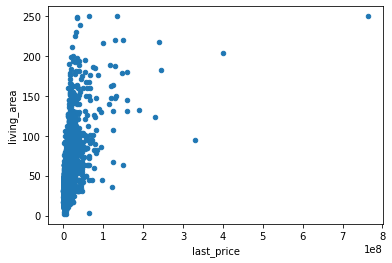

In [49]:
df.plot(x='last_price', y='living_area', kind='scatter')

In [50]:
print(df['last_price'].corr(df['living_area']))

0.5225392151837804


Аналогичный результат, как и с общей площадью, показала взаимосвязь цены и жилой площади.

<AxesSubplot:xlabel='last_price', ylabel='kitchen_area'>

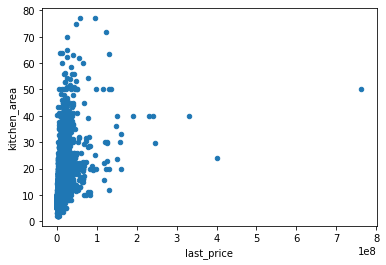

In [51]:
df.plot(x='last_price', y='kitchen_area', kind='scatter')

In [52]:
print(df['last_price'].corr(df['kitchen_area']))

0.4403916335021814


Коэффициент корреляции площади кухни и цены ниже,чем с общей площадью. Так как внутри квартиры планировку можно сделать практически в любом виде, площадь квартиры может быть, например, большая, а кухни - маленькая (если в ней нет особой потребности).

AxesSubplot(0.125,0.125;0.775x0.755)


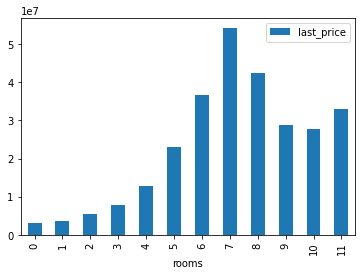

In [53]:
df_rooms_price = df.pivot_table(index='rooms', values='last_price')
print (df_rooms_price.plot.bar())

В диапазоне 1-7 комнат цена прямо пропорционально увеличивается количеству комнат. Однако от 8 комнат в квартире нельзя сказать, что зависимость настолько закономерна. Это может быть связано с планировкой квартиры и размером комнат.

AxesSubplot(0.125,0.125;0.775x0.755)


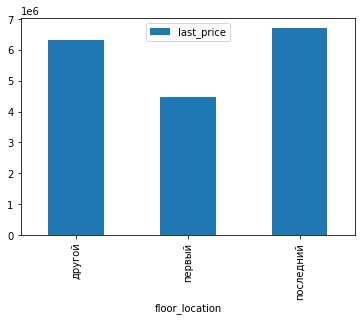

In [54]:
df_floor_location_price = df.pivot_table(index='floor_location', values='last_price')
print (df_floor_location_price.plot.bar())

Самая маленькая цена наблюдается у квартир на первом этаже, что вполне логично. Отсутствие балконов, слишком хорошая слышимость, также высокая проходимость остальных жителей подъезда влияет на цену.

AxesSubplot(0.125,0.125;0.775x0.755)


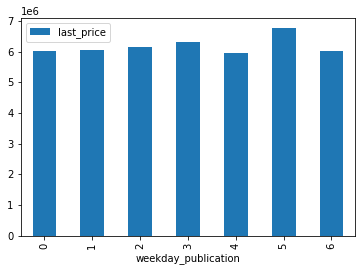

In [55]:
df_weekday_pub_price = df.pivot_table(index='weekday_publication', values='last_price')
print (df_weekday_pub_price.plot.bar())

Не наблюдается взаимосвязь цены за объект с днём размещения публикации, данные распределены равномерно.

AxesSubplot(0.125,0.125;0.775x0.755)


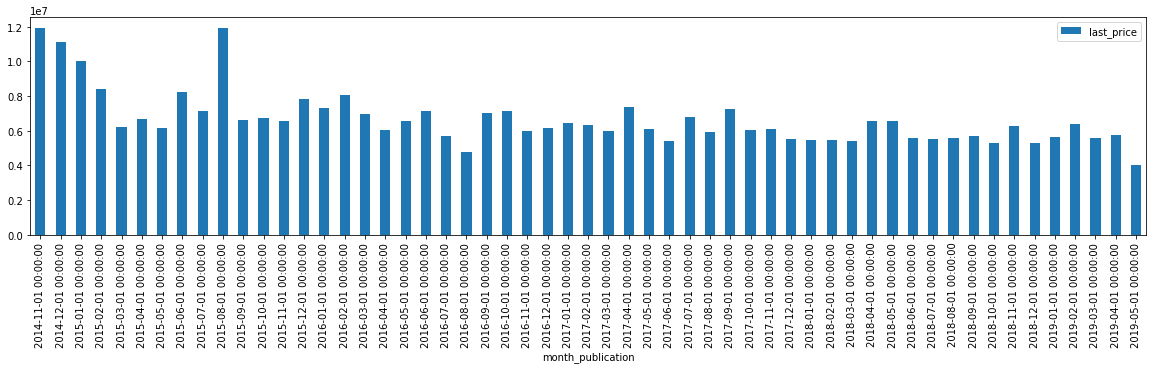

In [56]:
df_month_pub_price = df.pivot_table(index='month_publication', values='last_price')
print (df_month_pub_price.plot.bar(figsize=(20,4)))

Также нет взаимосвязи между месяцем публикации объявления, данные не отличаются в зависимости от месяца и сезона.

AxesSubplot(0.125,0.125;0.775x0.755)


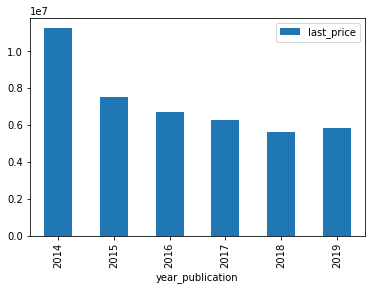

In [57]:
df_year_pub_price = df.pivot_table(index='year_publication', values='last_price')
print (df_year_pub_price.plot.bar())

Анализируя публикации объявлений в разрезе года, заметен всплеск в один из годов. В 2014 году был кризис, который спроворцировал большой спрос на недвижимость. Люди стремились вложить свои накопления, отсюда и повышенная цена при увеличенном спросе и прежнем предложении.

In [58]:
df_med_price = df.pivot_table(index='locality_name', values='cost_one_meter', aggfunc=['median','count'])
#print (df_mid_price.columns)
#print (df_mid_price)
df_med_price.columns = ['mean_cost_one_meter', 'count_publications']
print (df_med_price.sort_values(by='count_publications', ascending=False).head(10))

                 mean_cost_one_meter  count_publications
locality_name                                           
Санкт-Петербург        102961.918195               13419
Мурино                  84922.646605                 504
Кудрово                 94444.444444                 423
Шушары                  76220.394737                 408
Всеволожск              65789.473684                 336
Колпино                 73913.043478                 307
Пушкин                  97826.086957                 303
Парголово               91346.153846                 287
Гатчина                 67180.706522                 268
Выборг                  56960.594315                 208


In [59]:
print ('Населённые пункты с самой высокой стоимостью квадратного метра:\n\n', 
       df_med_price.sort_values(by='mean_cost_one_meter', ascending=False).head(10))


print ('\n\n\nНаселённые пункты с самой низкой стоимостью квадратного метра:\n\n', 
       df_med_price.sort_values(by='mean_cost_one_meter', ascending=False).tail(10))

Населённые пункты с самой высокой стоимостью квадратного метра:

                  mean_cost_one_meter  count_publications
locality_name                                           
Лисий Нос              113728.348730                   2
Санкт-Петербург        102961.918195               13419
Зеленогорск            100000.000000                  21
Сестрорецк              98364.164501                 162
Пушкин                  97826.086957                 303
Левашово                96997.690531                   1
Кудрово                 94444.444444                 423
Парголово               91346.153846                 287
Мистолово               90229.885057                   9
Стрельна                87323.348694                  38



Населённые пункты с самой низкой стоимостью квадратного метра:

                  mean_cost_one_meter  count_publications
locality_name                                           
Лужайка                 15000.000000                   1
Житково    

Выделяем квартиры Питера и считаем стоимость за км:

In [60]:
df['mean_km_price'] = df['last_price']/df['km_to_centre']
df_spb = df.query('locality_name == "Санкт-Петербург"')
df_spb_price = df.groupby('km_to_centre').agg({'mean_km_price':'mean'})

print (df_spb_price)

              mean_km_price
km_to_centre               
0.0                     inf
1.0            1.874815e+07
2.0            8.778142e+06
3.0            3.461074e+06
4.0            3.155000e+06
5.0            2.647576e+06
6.0            2.270410e+06
7.0            1.965126e+06
8.0            1.075521e+06
9.0            7.329187e+05
10.0           6.158919e+05
11.0           5.419485e+05
12.0           4.862129e+05
13.0           4.559833e+05
14.0           3.904203e+05
15.0           3.715889e+05
16.0           3.250722e+05
17.0           2.995134e+05
18.0           2.681221e+05
19.0           2.395215e+05
20.0           2.340140e+05
21.0           2.218415e+05
22.0           2.174273e+05
23.0           1.932188e+05
24.0           1.642484e+05
25.0           1.889453e+05
26.0           1.862037e+05
27.0           2.042780e+05
28.0           1.663709e+05
29.0           1.442414e+05
30.0           1.433863e+05
31.0           1.491126e+05
32.0           1.307898e+05
33.0           1.290

<AxesSubplot:xlabel='km_to_centre'>

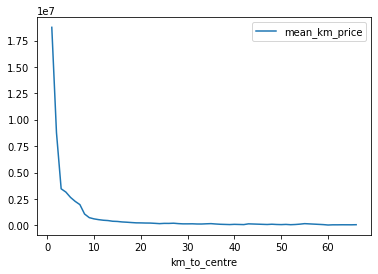

In [61]:
df_spb_price.plot()

На графике видно, что от 10 км и более цена сильно не отличается, однако с приближением к центру цена за км увеличивается в геометрической прогрессии. Особенно сильно заметен рост от 3 км и выше.

**Вывод:**  
Таким образом, после анализа взаимосвязи полной стоимости с прочими показателями были выявлено следующее:  
* Высокая корреляция наблюдается у стоимости квартиры и общей, жилой, а также площади кухни. БОльшая площадь подразумевает бОльшую стоимость квартиры.  
* Рост цены зависит также от количества комнат, поскольку чем больше площадь квартиры, тем больше возможно спроектировать комнат.  
* В зависимости от этажа, на котором располагается квартира, зависит и цена. Самая низкая стоимость у квартир на первом этаже.  
* Чем ближе квартира к центру, тем выше средняя цена за км, особенно сильный рост цены начинается от 10 км и ближе.

### Общий вывод

Для анализа влияния различных факторов на продажу квартир Санкт-Петербурга и Ленинградской области было проведено исследование на основе предоставленных статистических данных. Исследование состояло из нескольких этапов:  
1. Предобработка данных;  
2. Добавление новых столбцов;  
3. Проведение исследовательского анализа данных.  


**Первый этап**  
Для более корректного и наглядного отображения данных:  
* были устранены пустые значения;  
* преобразованы типы данных в столбцах, где это возможно;  
* ликвидированы неявные дубликаты;  
* удалены из общего массива данных самые значительные выбросы по основным показателям.  

**Второй этап**  
Для более подробных подсчётов были добавлены следующие показатели:

* цена за один метр;
* выделены в отдельные столбцы день, месяц и год публикации объявления, впоследствии они понадобятся для анализа взаимосвязи с ценой объекта;
* расстояние от квартиры до центра города в км для более наглядного представления данных.  

**Третий этап**  
После проведения исследовательского анализа можно представить портрет наиболее часто продаваемой квартиры:  
* Общая площадь квартиры около 50 м2;  
* Жилая площадь занимает примерно половину общей площади - 25 м2;  
* Площадь кухни составляет около 10 м2;  
* Общая стоимость квартиры варьируется от 3 до 5 млн;  
* Количество комнат в такой квартире от 2 до 4-ёх;  
* Квартира находится на нижних этажах дома (до 4 этажа включительно);  
* Квартира находится вблизи от центра, приблизительно в 2-ух км;  
* Рядом с квартирой находится парк.  

Согласно анализу большинство объявлений было выложено в четверг, в выходные наблюдается спад активности. Что касается месяца, рост количества публикаций отмечен в феврае после закономерного спада в предновогодний месяц и январские праздники.Чаще всего объявление висит около трёх месяцев.  

Что касается влияния факторов на стоимость квартиры - высокая корреляция наблюдается у полной стоимости и общей, жилой,площади кухни, а также количества комнат. Чем больше размер квартиры, тем дороже она стоит.
Чем ближе квартира к центру, тем выше средняя цена за км, особенно сильный рост цены начинается от 10 км и ближе.   
  
  

Таким образом, опираясь на данный анализ, определён наиболее привлекательный вариант для покупателя, какие параметры важны при продаже квартиры, какие имеют меньший вес.
